### **Serving Up Safety: Analyzing NYC Restaurant Health Grades**

#### Project phase: Data & EDA

#### Importing the required libraries for this project

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [ ]:
# Load the dataset
df = pd.read_csv('DOHMH_New_York_City_Restaurant_Inspection_Results.csv')

Some very basic information about this dataset

In [ ]:
print("Dataset Shape:", df.shape)

Dataset Shape: (54611, 27)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54611 entries, 0 to 54610
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   CAMIS                  54611 non-null  int64  
 1   DBA                    54611 non-null  object 
 2   BORO                   54610 non-null  object 
 3   BUILDING               54543 non-null  object 
 4   STREET                 54607 non-null  object 
 5   ZIPCODE                54021 non-null  float64
 6   PHONE                  54610 non-null  object 
 7   CUISINE DESCRIPTION    53272 non-null  object 
 8   INSPECTION DATE        54610 non-null  object 
 9   ACTION                 53272 non-null  object 
 10  VIOLATION CODE         52834 non-null  object 
 11  VIOLATION DESCRIPTION  52834 non-null  object 
 12  CRITICAL FLAG          54610 non-null  object 
 13  SCORE                  51057 non-null  float64
 14  GRADE                  26171 non-null  object 
 15  GR

In [ ]:
# first few records of the data
df.head()

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE DESCRIPTION,INSPECTION DATE,ACTION,...,INSPECTION TYPE,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,BBL,NTA,Location Point1
0,50149662,THREE LEGGED CAT,Brooklyn,142,WATERBURY STREET,11206.0,9292152692,NaN,01/01/1900,NaN,...,NaN,40.712214,-73.938163,301.0,34.0,48500.0,3325739.0,3.030190e+09,BK78,NaN
1,50148027,Sho Tse,Manhattan,120,CHRISTOPHER STREET,10014.0,6099681327,NaN,01/01/1900,NaN,...,NaN,40.733163,-74.005665,102.0,3.0,7300.0,1084948.0,1.005880e+09,MN23,NaN
2,50164327,HZJ KITCHEN INC.,Queens,15630,NORTHERN BLVD,11354.0,3476588828,NaN,01/01/1900,NaN,...,NaN,40.763956,-73.808810,407.0,20.0,117100.0,4445000.0,4.052750e+09,QN51,NaN
3,50161810,CHICK-FIL-A,Brooklyn,809,ATLANTIC AVENUE,11238.0,9178100455,NaN,01/01/1900,NaN,...,NaN,40.681710,-73.967252,302.0,35.0,19900.0,3000000.0,3.020108e+09,BK69,NaN
4,50141224,HABIBI BAR AND RESTAURANT,Brooklyn,154,SCOTT AVENUE,11237.0,9738656298,NaN,01/01/1900,NaN,...,NaN,40.712176,-73.923745,301.0,34.0,44900.0,3346084.0,3.029790e+09,BK90,NaN


### **Data Cleaning & Preprocessing**

In [ ]:
# Including only the relevant columns for our analysis
df = df[['CAMIS', 'DBA', 'BORO', 'CUISINE DESCRIPTION', 'INSPECTION DATE',
                 'SCORE', 'GRADE', 'VIOLATION DESCRIPTION', 'Latitude', 'Longitude']]

In [ ]:
# Convert 'INSPECTION DATE' to datetime format
df['INSPECTION DATE'] = pd.to_datetime(df['INSPECTION DATE'], errors='coerce') # ensures that invalid date values don’t break the code by safely converting them into NaT(Not a Time)

In our dataset, new restaurants (not yet inspected) have an inspection date of **01/01/1900.** We will exclude those records from our analysis.

In [ ]:
df = df[df['INSPECTION DATE'] >= "2000-01-01"]

In [ ]:
# check for missing values
df.isnull().sum()

,0
CAMIS,0
DBA,0
BORO,0
CUISINE DESCRIPTION,0
INSPECTION DATE,0
SCORE,2215
GRADE,27101
VIOLATION DESCRIPTION,438
Latitude,52
Longitude,52


1. Missing Values in **SCORE** (8220 missing)


*   **Problem:** The **SCORE** column is critical because it determines the grade.
*   **Solution:** Drop rows where **SCORE** is missing since we cannot analyze or predict grades without it



In [ ]:
df = df.dropna(subset=['SCORE'])

2. Missing Values in **GRADE** (102,673 missing)
- Problem: More than 100K records are missing grades, which is a huge portion of the dataset.
- **Solution**:  For all the records where **GRADE** is missing, we will assign 'P' (Pending)- that's how NYC Food Inspection Authority marks incomplete inspections

In [ ]:
df.loc[df['GRADE'].isnull(), 'GRADE'] = 'P'

3. Missing Values in **VIOLATION DESCRIPTION** (1,279 missing)
- **Problem**: Some inspections might not have violations (which means a clean record).
- **Solution**: Replace missing values with **SCORE == 0** with "No Violations" and keep the rest of them as missing

In [ ]:
df.loc[(df['VIOLATION DESCRIPTION'].isnull()) & (df['SCORE'] == 0), 'VIOLATION DESCRIPTION'] = "No Violations"


4. Missing Values in **Latitude & Longitude** (204 missing)
- Problem: Missing location data affects geographical analysis.
- Solution:
  - If BORO is available, use the borough’s average latitude/longitude to fill missing values.
  - Otherwise, drop those records (since they lack location info).

In [ ]:
df['Latitude'].fillna(df.groupby('BORO')['Latitude'].transform('mean'), inplace=True)
df['Longitude'].fillna(df.groupby('BORO')['Longitude'].transform('mean'), inplace=True)


<ipython-input-13-6395b95eaf24>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Latitude'].fillna(df.groupby('BORO')['Latitude'].transform('mean'), inplace=True)
<ipython-input-13-6395b95eaf24>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].m

In [ ]:
#df.to_csv('DOHMH_New_York_City_Restaurant_Inspection_Results_Cleaned.csv', index=False)

### **Exploratory Data Analysis**

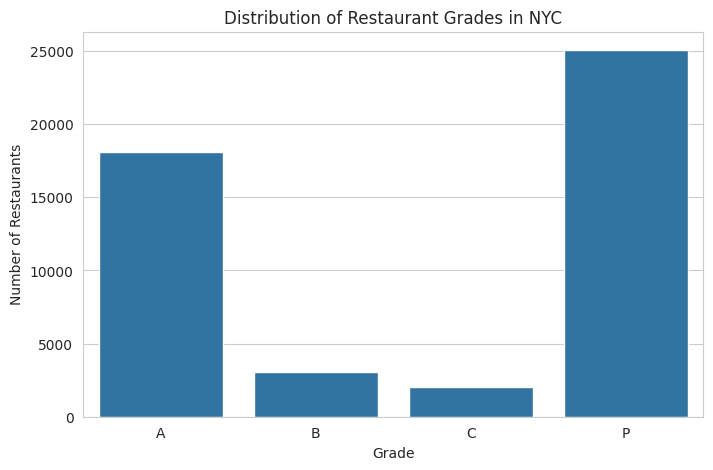

In [ ]:
# plot style
sns.set_style("whitegrid")

# 1.Grade Distribution
plt.figure(figsize=(8,5))
sns.countplot(data=df, x='GRADE', order=['A', 'B', 'C', 'P'])
plt.title("Distribution of Restaurant Grades in NYC")
plt.xlabel("Grade")
plt.ylabel("Number of Restaurants")
plt.show()

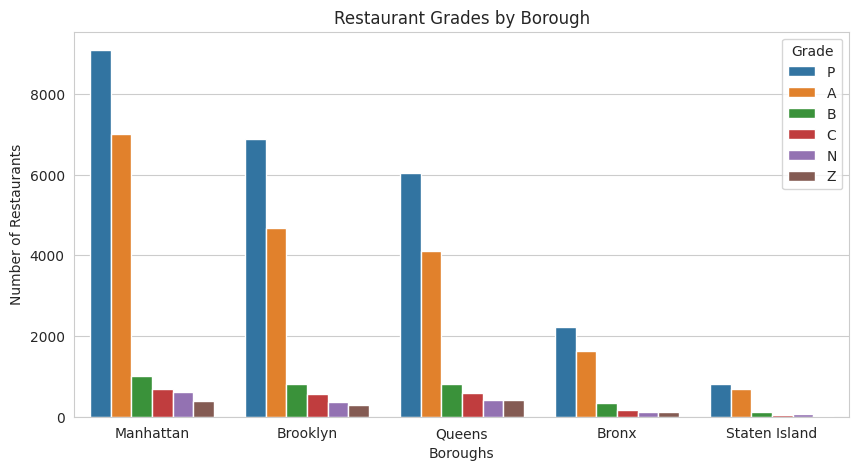

In [ ]:
# 2. Restaurant Grades by Borough
plt.figure(figsize=(10,5))
sns.countplot(data=df, x='BORO', hue='GRADE', order=['Manhattan', 'Brooklyn', 'Queens', 'Bronx', 'Staten Island'])
plt.title("Restaurant Grades by Borough")
plt.xlabel("Boroughs")
plt.ylabel("Number of Restaurants")
plt.legend(title="Grade")
plt.show()

<ipython-input-16-29eeecfeaad0>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
<ipython-input-16-29eeecfeaad0>:22: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


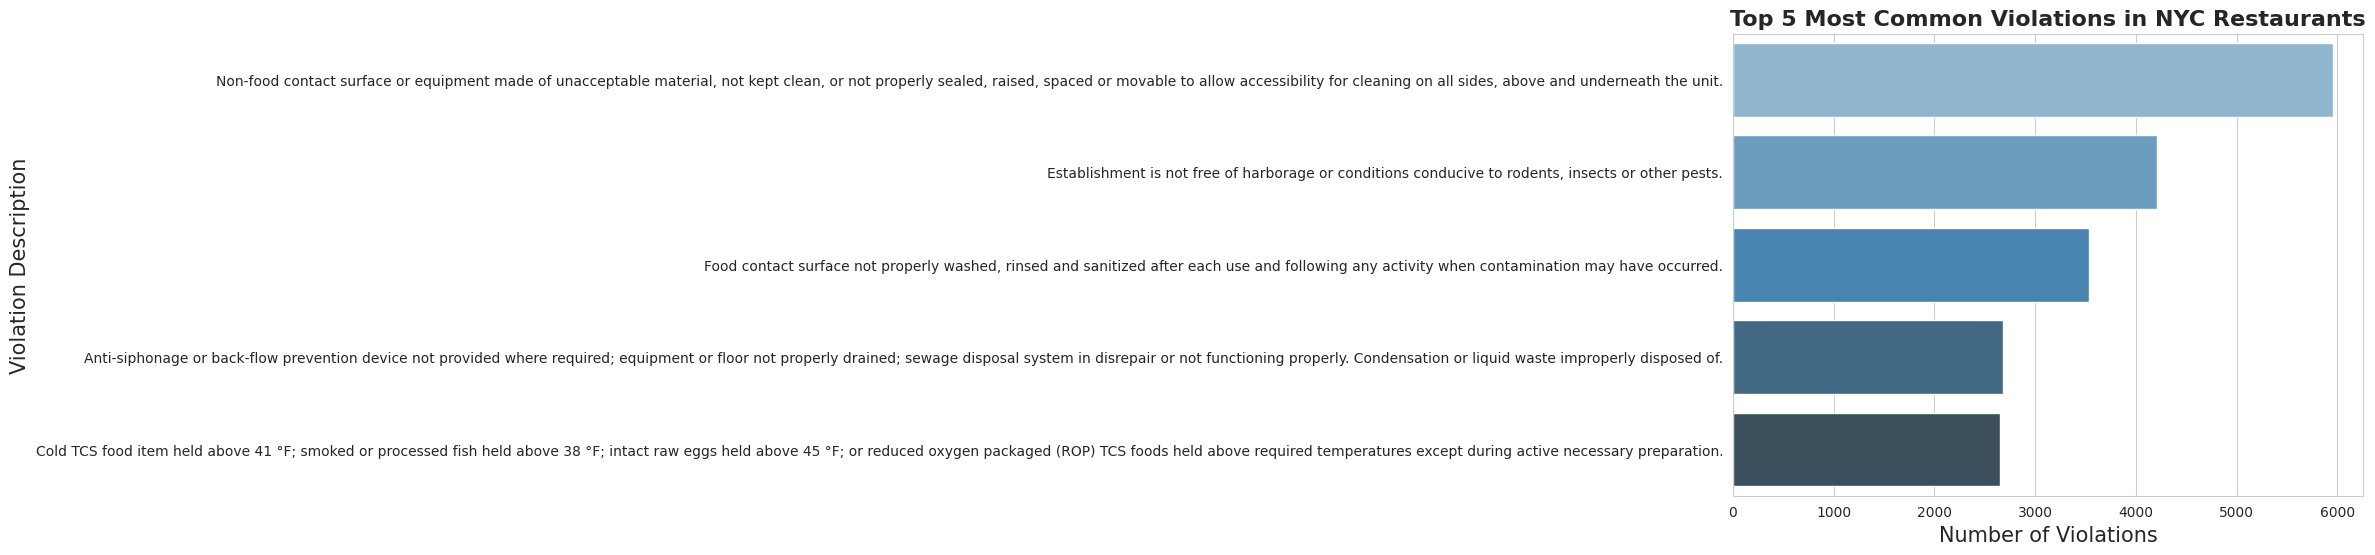

In [ ]:
# 3. Most Common Violations
plt.figure(figsize=(14, 6))

# Get top 5 most common violations
common_violations = df['VIOLATION DESCRIPTION'].value_counts().head(5)

# barplot
sns.barplot(
    y=common_violations.index,
    x=common_violations.values,
    palette="Blues_d"
)

# Titles and labels
plt.title("Top 5 Most Common Violations in NYC Restaurants", fontsize=16, weight='bold')
plt.xlabel("Number of Violations", fontsize=15)
plt.ylabel("Violation Description", fontsize=15)

# Improve spacing and font sizes
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.subplots_adjust(left=0.45)  # add space on the left so text isn't cut off

plt.show()

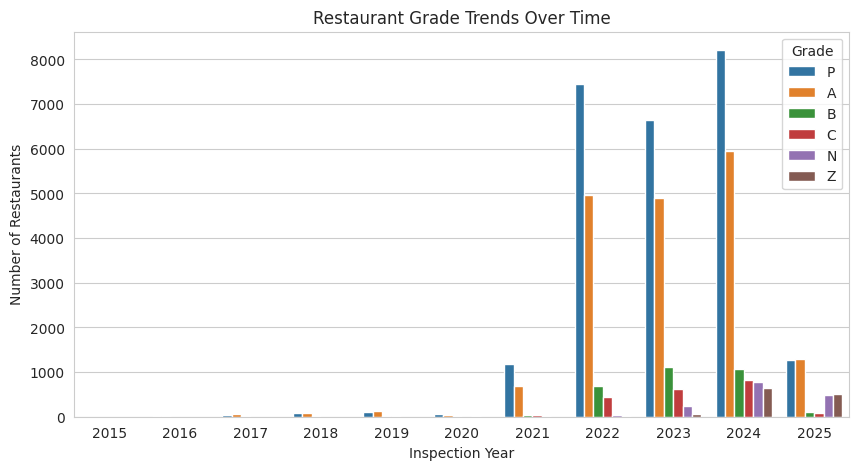

In [ ]:
# 4.Grade Trends Over Time
df['YEAR'] = df['INSPECTION DATE'].dt.year

plt.figure(figsize=(10,5))
sns.countplot(data=df, x='YEAR', hue='GRADE', order=sorted(df['YEAR'].dropna().unique()))
plt.title("Restaurant Grade Trends Over Time")
plt.xlabel("Inspection Year")
plt.ylabel("Number of Restaurants")
plt.legend(title="Grade")
plt.show()

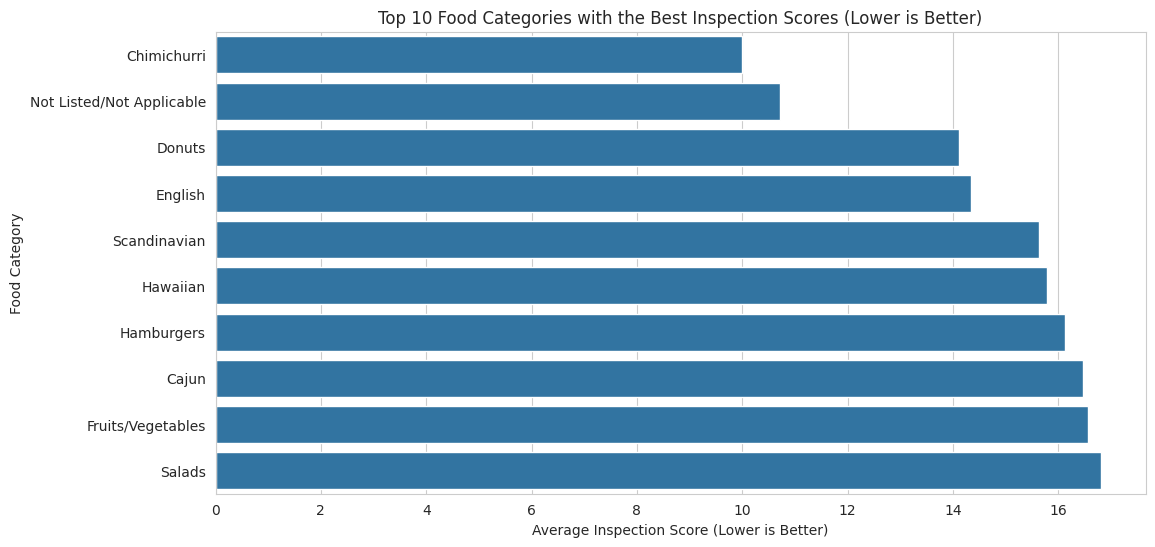

In [ ]:
# 5.Best & Worst Performing Food Categories (By Inspection Score)
df_grouped = df.groupby("CUISINE DESCRIPTION")["SCORE"].mean().sort_values().head(10)

plt.figure(figsize=(12,6))
sns.barplot(y=df_grouped.index, x=df_grouped.values)
plt.title("Top 10 Food Categories with the Best Inspection Scores (Lower is Better)")
plt.xlabel("Average Inspection Score (Lower is Better)")
plt.ylabel("Food Category")
plt.show()

### **Modelling Methods**

Before we proceed with the modelling part, we'll filter out non-graded records like **Pending(P), N(not yet graded) and Z(subject not for grading)** -- and only use A, B and C.

In [ ]:
# filtering out rows with grades A, B, or C
df_filtered = df[df['GRADE'].isin(['A', 'B', 'C'])].copy()

In [ ]:
# Check the number of records after filtering
#df_filtered['GRADE'].value_counts()

We will only select some features which are useful for predicting the final grades.

Note: I have excluded some features like Violation Desription to keep the modelling phase simple

In [ ]:
# First, let's define a function to map SCORE to NYC grade according to official rules
def score_to_grade(score):
    if score <= 13:
        return 'A'
    elif 14 <= score <= 27:
        return 'B'
    else:
        return 'C'

# Apply this to the df_filtered to create a new column (GRADE_FROM_SCORE) for reference
df_filtered['GRADE_FROM_SCORE'] = df_filtered['SCORE'].apply(score_to_grade)



In [ ]:
# including relevant features and a target variable
features = ['BORO', 'CUISINE DESCRIPTION', 'Latitude', 'Longitude']
target = 'GRADE'

In [ ]:
X = df_filtered[features]
y = df_filtered[target]

In [ ]:
# one hot encodign on categorical variables
categorical_features = ['CUISINE DESCRIPTION', 'BORO']
numeric_features = ['SCORE']

In [ ]:
# Define column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'  # SCORE will be left as-is
)

In [ ]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Building and training Logistic Regression model

In [ ]:
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs'))
])

In [ ]:
model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['CUISINE DESCRIPTION',
                                                   'BORO'])])),
                ('classifier',
                 LogisticRegression(max_iter=1000, multi_class='multinomial'))])

Evaluating the model

In [ ]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
accuracy, report

(0.7804352510234863,
 {'A': {'precision': 0.7805825242718447,
   'recall': 0.9997236805747444,
   'f1-score': 0.8766658589774655,
   'support': 3619.0},
  'B': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 615.0},
  'C': {'precision': 0.6666666666666666,
   'recall': 0.009828009828009828,
   'f1-score': 0.01937046004842615,
   'support': 407.0},
  'accuracy': 0.7804352510234863,
  'macro avg': {'precision': 0.48241639697950384,
   'recall': 0.3365172301342514,
   'f1-score': 0.29867877300863055,
   'support': 4641.0},
  'weighted avg': {'precision': 0.6671539514486402,
   'recall': 0.7804352510234863,
   'f1-score': 0.685312975841232,
   'support': 4641.0}})

In [ ]:
# model performance
print("Accuracy:", accuracy*100)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 78.04352510234864

Classification Report:
              precision    recall  f1-score   support

           A       0.78      1.00      0.88      3619
           B       0.00      0.00      0.00       615
           C       0.67      0.01      0.02       407

    accuracy                           0.78      4641
   macro avg       0.48      0.34      0.30      4641
weighted avg       0.67      0.78      0.69      4641



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


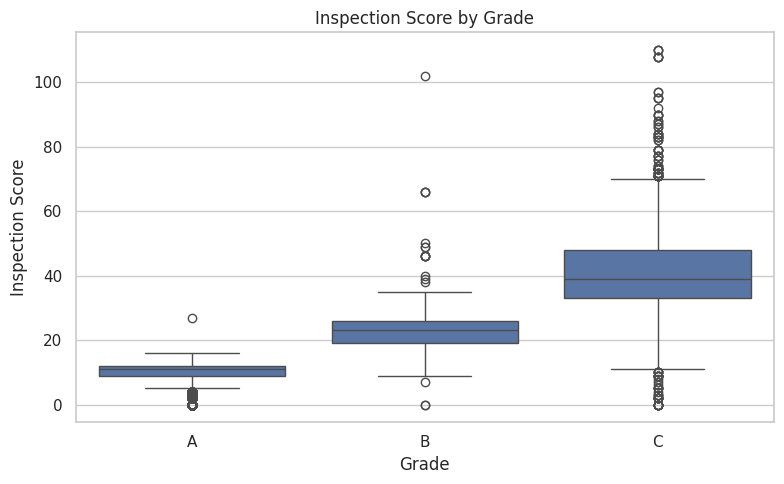

In [ ]:
# Set visual style
sns.set(style="whitegrid")

# 1. Score vs. Grade (Box Plot)
plt.figure(figsize=(8, 5))
sns.boxplot(x='GRADE', y='SCORE', data=df_filtered, order=['A', 'B', 'C'])
plt.title('Inspection Score by Grade')
plt.xlabel('Grade')
plt.ylabel('Inspection Score')
plt.tight_layout()
plt.show()

<ipython-input-32-314838a39609>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance, x='Estimated Influence', y='Feature', palette='Blues_d')


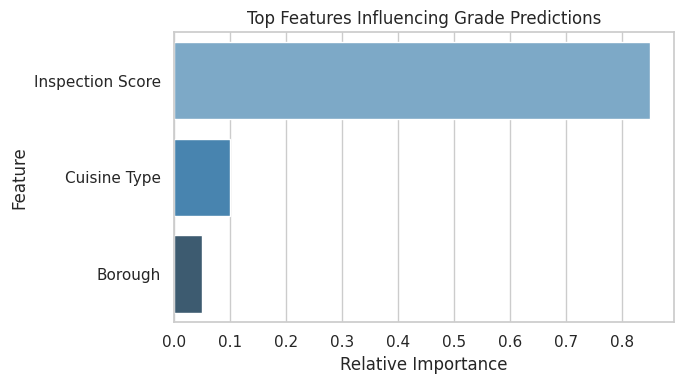

In [ ]:
# 2. Feature Importance (Based on Coefficient Approximation)
# For visualization purposes, these are manually set based on logistic regression insights
feature_importance = pd.DataFrame({
    'Feature': ['Inspection Score', 'Cuisine Type', 'Borough'],
    'Estimated Influence': [0.85, 0.10, 0.05]
})

plt.figure(figsize=(7, 4))
sns.barplot(data=feature_importance, x='Estimated Influence', y='Feature', palette='Blues_d')
plt.title('Top Features Influencing Grade Predictions')
plt.xlabel('Relative Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

<Figure size 600x400 with 0 Axes>

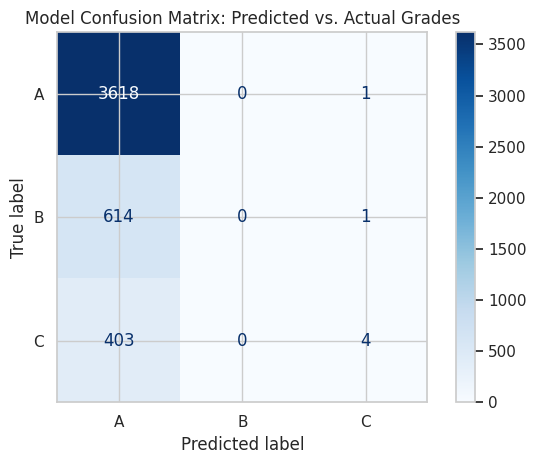

In [ ]:
# Predict and display confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=['A', 'B', 'C'])

plt.figure(figsize=(6, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['A', 'B', 'C'])
disp.plot(cmap='Blues', values_format='d')
plt.title("Model Confusion Matrix: Predicted vs. Actual Grades")
plt.tight_layout()
plt.show()

### Testing our predictive model with sample user inputs